# Chapter 5 : Pretraining on unlabeled data

- basic model evaluation to measure the quality of the generated text
- how to load pretrained weights

In [1]:
import torch
from chapter_04 import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

In [2]:
import tiktoken
from chapter_04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:", token_ids_to_text(token_ids, tokenizer))

Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren


The goal of training an LLM is to maximize the lilkelihood of the correct token, which involves increasing the probaility relative to other tokens
Part of the text evaluation is to measure "how far" the generated tokens are from the correct predictions (targets). We use this information to adjust the model weights

The model training aims to increase the softmax probability in the index positions corresponding to the correct target token IDs. This softmax probability is also used in the evaluation metric to numerically assess the model's generated outputs: the higher the proba in the correct positions, the better

Working with logarithms of probability scores is more manageable in mathematical optimization than handling the scores directly

![log_likelihood](/home/mat/Documents/whisper_triton/understand_LLMs/log_likelihood.png)


The goal is to get the average log probability as close to 0 as possible by updating the model's weights as part of the training process
In DL. the goal is to bring the negative average log proba to 0. It's called the **cross entropy loss**

At its core the cross entropy loss is a popular measure that measures the difference between 2 probability distributions - typically tge true distribution of labels (here tokens in dataset) and the predicted distribution from a model

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print()
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(f"{log_probas=}")

avg_log_probas = torch.mean(log_probas)
print(f"{avg_log_probas=}")

neg_avg_log_probas = avg_log_probas * -1
print(f"{neg_avg_log_probas=}")
print()
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

# For the cross_entropy loss function in PyTorch we want to flatten these tensors by combining them over the batch dimension
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

print()
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
log_probas=tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
avg_log_probas=tensor(-10.7940)
neg_avg_log_probas=tensor(10.7940)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])

tensor(10.7940)


# Perplexity

It's a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling. It can provide a more intrepretable way to understand the uncertainty of a model in predicting the next token in a sequence

Perplexity measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

Perplexity can be calculated as `perplexity = torch.exp(loss)` which return `tensor(48725.8203)` when applied to the previously calculated loss

Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step.
In the given example, this would translate to the model being unsure about which among 48,725 tokens in the vocabulary to generate as the next token

# Train and validation

![dataloader](dataloader.png)

In [4]:
file_path = "the-verdict.txt"
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [5]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("\nTokens: ", total_tokens)

Characters:  20479

Tokens:  5145


In [6]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [7]:
from chapter02 import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,       # smal batch size to reduce the computational resource demand
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [8]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape) # 9 training set batches with 2 samples and 256 tokens each

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [9]:
# calculate the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

# iterates over all batches in a given data loader, accumulates the loss and then computes the averages over the total number of batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("\nValidation loss:", val_loss)

Training loss: 10.98758316040039

Validation loss: 10.981104850769043


# Code for pretraining the LLM

![training loop](training_loop.png)

In [11]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # resets loss gradients from the previous batch iteration
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()     # calculates loss gradiens
            optimizer.step()    # updates model wights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(      # optional evaluation step
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f},"
                      f"Val loss {val_loss:.3f}"
                )
        
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

# corresponds to step 7 in the figure. 
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()        # Dropout is disabled during evaluation for stable, reproducible results
    with torch.no_grad():       # Disable gradient tracking, which is not required during evaluation, to reduce the computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss            

# provides a concrete text example generated by the model to judge its capabilities during training
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=5, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
    

# AdamW

Adam optimizers are a popular choice for training DNNs. However in our training loop, we opt for the **AdamW** optimizer. It's a variant of Adam that improves the weight decay approach, which aims to minimize model complexity and prevent overfitting by penalizer larger weights. This adjustment allows AdamW to achieve more effective regularization and better generalization.

In [15]:
torch.manual_seed(123)
device = 'cpu'
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0004, weight_decay=0.1     # the parameters() method returns all trainable weight parameters of the model
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=5, eval_iter=5, start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.783,Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985,Val loss 8.335
Every effort moves you,,,,,
Ep 2 (Step 000010): Train loss 6.753,Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114,Val loss 6.573
Every effort moves you, and,, and
Ep 3 (Step 000020): Train loss 5.525,Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324,Val loss 6.387
Every effort moves you, and to the picture
Ep 4 (Step 000030): Train loss 4.761,Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461,Val loss 6.258
Every effort moves you of the to the picture
Ep 5 (Step 000040): Train loss 3.833,Val loss 6.196
Every effort moves you know the "Oh
Ep 6 (Step 000045): Train loss 3.352,Val loss 6.139
Ep 6 (Step 000050): Train loss 2.861,Val loss 6.112
Every effort moves you know; and my dear
Ep 7 (Step 000055): Train loss 2.347,Val loss 6.138
Ep 7 (Step 000060): Train loss 2.084,Val loss 6.179
Every effort moves you know," was one of
Ep 8 (Step 000065): Train loss 1.521,Val loss 6.176
Ep 8

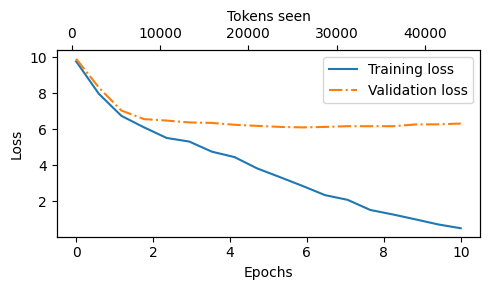

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# the divergence indicates that the model is overfitting to the training data

# Decoding strategies to control randomness

text generation strategies = decoding strategies

2 techniques covered:
- temperature scaling
- tok-k sampling
  


In [17]:
model.to('cpu')
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

In [20]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




# Temperature scaling

technique that adds a probabilistic selection process to the next-token generation task.
Previously in `generate_text_simple` function we always sampled the token with the highest probability as the next token using `torch.argmax` also known as **greedy decoding**.
To generaqte more variety, we can replace `argmax` with a function that samples from a probability distribution 


Temperatures greater than 1 result in more uniformly distributed probabilities and temperatures smaller than 1 witll result in more confident (sharper or more peaky) distributions

In [21]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

In [22]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [23]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [24]:
torch.manual_seed(123) 
# multinomial function samples the next token proportional to its probability scoree
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [25]:
# function that repeats the sampling 1000 times

def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item()
             for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


In [27]:
# We can further control the distribution and selection process via concept called TEMPERATURE SCALING. This is just a fancy decription for dividing the logits by a number greater than 0
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


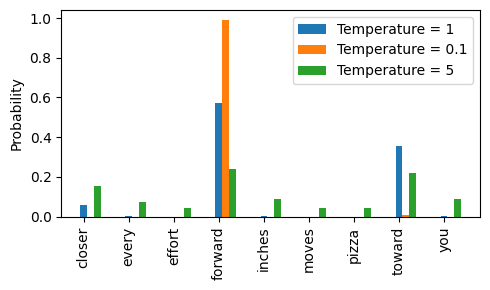

In [28]:
temperatures = [1,0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# Top-k sampling

In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and exclude all other tokens from the selection process by masking their probability scores

It replaces all nonselected logits with negative infinity value `-inf` such that when computing the softmax values, the probability scores of the non-top-k tokens are 0 and the remaining probabilities sum up to 1


In [29]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits: ", top_logits)
print("Top positions: ", top_pos)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top positions:  tensor([3, 7, 0])


In [30]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [32]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

# tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
# we can now apply temperature scaling and multinomial function for probabilistic sampling to select the next token among these 3 non-zero probability scores to generate the next token

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [33]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0,
             top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [34]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


# Loading and saving model weights in PyTorch

The recommended way to save a PyTorch model is to save a model's `state_dict`, a dictionary mapping each layer to its parameters using the `torch.save` function

In [35]:
torch.save(model.state_dict(), "model.pth")


In [36]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

/tmp/ipykernel_87897/936198766.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth", map_location=device))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

If we plan to continue pretraining a model later saving the optimizer state is also recommended

Adaptive optimizers such as AdamW store additional parameters for each model weight,
AdamW uses historical data to adjust learning rates for each model parameter dynamically. Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means it will lose the ability to generate coherent text. Using `torch.save`, we can save both the model and optimizer `state_dict` contents:

In [37]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
    )

In [38]:
# Then we can restore the model and optimizer states by first loading the saved data via `torch.load` and then using `load_state_dict` method

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

/tmp/ipykernel_87897/3263436288.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth", map_location=device)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=

# Loading pretrained weights from OpenAI

